# Faster R-CNN with Pytorch
Source:  
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


## Import things

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random

import tifffile as tiff
from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage  
import matplotlib.pyplot as plt

import pycocotools

import torch
import torchvision
import torch.utils.data

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import utils
import transforms as T
from engine import train_one_epoch, evaluate

In [2]:
image_path = '../train/images/slices/'
images = os.listdir(image_path)

data_path = '../CSVs'
datafiles = os.listdir(data_path)

### Some functions

In [3]:
# this function turns the dataframe of coordinates into arrays

def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
    "xmax", "ymax"]].values
   
    return boxes_array

In [4]:
## This model will give you bounding boxes and masks

def get_model(num_classes):
   # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
   # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
    return model

In [5]:
# This function converts an image into a PyTorch Tensor
# and flips the image horizontally sometimes during training

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Make a Glomeruli class 

In [6]:
class GlomeruliDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'train/images/slices')))
        self.path_to_data_file = data_file
        
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root,'train/images/slices', self.imgs[idx])

        img = tiff.imread(img_path)
        if len(img.shape) == 5:
            img = img.squeeze().transpose(1, 2, 0)
                    
        #boxes
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [7]:
# Try out the class and see what it gives you:
dataset = GlomeruliDataset(root = '..', 
                           data_file = '../CSVs/glomeruli_tiles.csv')
dataset.__getitem__(111)

(array([[194, 112, 152, ..., 180, 187, 161],
        [220, 137, 127, ...,  78, 132, 210],
        [209, 152, 116, ...,  87, 104, 165],
        ...,
        [127, 141, 171, ..., 201, 202, 136],
        [167, 169, 171, ..., 201, 201, 219],
        [157, 123, 103, ..., 197, 206, 217]], dtype=uint8),
 {'boxes': tensor([[  0., 191.,  88., 347.],
          [  0.,  38.,  84., 104.]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([111]),
  'area': tensor([13728.,  5544.]),
  'iscrowd': tensor([0, 0])})

### Setting up datasets

In [8]:
# use our dataset and defined transformations
dataset = GlomeruliDataset(root = '..',
                           data_file = '../CSVs/glomeruli_tiles.csv', 
                           transforms = get_transform(train=True))

dataset_test = GlomeruliDataset(root = '..', 
                                data_file = '../CSVs/glomeruli_tiles.csv',
                                transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-200])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=1, shuffle=False, num_workers=0,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=0,
         collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 1797 examples, 1597 are training and 200 testing


In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# our dataset has two classes only - glomeruli and not glomeruli
num_classes = 2

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001,
                            momentum=0.9, weight_decay=0.001)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [11]:
num_epochs = 10

for epoch in range(num_epochs):  
   # train for ten epochs, printing every 200 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=200)
    # update the learning rate
    lr_scheduler.step()
    
    #evaluate after each epoch:
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1597]  eta: 0:33:02  lr: 0.000000  loss: 1.1905 (1.1905)  loss_classifier: 0.7191 (0.7191)  loss_box_reg: 0.0247 (0.0247)  loss_objectness: 0.4266 (0.4266)  loss_rpn_box_reg: 0.0201 (0.0201)  time: 1.2412  data: 0.0120  max mem: 1088
Epoch: [0]  [ 200/1597]  eta: 0:10:08  lr: 0.000020  loss: 0.3102 (0.7462)  loss_classifier: 0.1474 (0.3454)  loss_box_reg: 0.1304 (0.1263)  loss_objectness: 0.0203 (0.2463)  loss_rpn_box_reg: 0.0034 (0.0282)  time: 0.4373  data: 0.0118  max mem: 1667
Epoch: [0]  [ 400/1597]  eta: 0:08:36  lr: 0.000040  loss: 0.3197 (0.5889)  loss_classifier: 0.1206 (0.2498)  loss_box_reg: 0.1181 (0.1377)  loss_objectness: 0.0356 (0.1778)  loss_rpn_box_reg: 0.0058 (0.0237)  time: 0.4162  data: 0.0111  max mem: 1667
Epoch: [0]  [ 600/1597]  eta: 0:07:07  lr: 0.000060  loss: 0.2419 (0.5130)  loss_classifier: 0.1007 (0.2057)  loss_box_reg: 0.1377 (0.1378)  loss_objectness: 0.0283 (0.1455)  loss_rpn_box_reg: 0.0033 (0.0241)  time: 0.4305  data: 0.0097  max me

Epoch: [2]  [ 400/1597]  eta: 0:08:30  lr: 0.000100  loss: 0.1357 (0.1902)  loss_classifier: 0.0387 (0.0623)  loss_box_reg: 0.0720 (0.0943)  loss_objectness: 0.0091 (0.0184)  loss_rpn_box_reg: 0.0040 (0.0153)  time: 0.4180  data: 0.0113  max mem: 1667
Epoch: [2]  [ 600/1597]  eta: 0:07:04  lr: 0.000100  loss: 0.1041 (0.1844)  loss_classifier: 0.0492 (0.0596)  loss_box_reg: 0.0556 (0.0903)  loss_objectness: 0.0046 (0.0181)  loss_rpn_box_reg: 0.0021 (0.0164)  time: 0.4366  data: 0.0108  max mem: 1667
Epoch: [2]  [ 800/1597]  eta: 0:05:40  lr: 0.000100  loss: 0.1709 (0.1835)  loss_classifier: 0.0444 (0.0597)  loss_box_reg: 0.0831 (0.0909)  loss_objectness: 0.0064 (0.0168)  loss_rpn_box_reg: 0.0017 (0.0161)  time: 0.4169  data: 0.0127  max mem: 1667
Epoch: [2]  [1000/1597]  eta: 0:04:15  lr: 0.000100  loss: 0.0955 (0.1776)  loss_classifier: 0.0288 (0.0572)  loss_box_reg: 0.0540 (0.0883)  loss_objectness: 0.0050 (0.0170)  loss_rpn_box_reg: 0.0027 (0.0152)  time: 0.4273  data: 0.0104  max me

Epoch: [4]  [ 800/1597]  eta: 0:05:41  lr: 0.000010  loss: 0.1645 (0.1670)  loss_classifier: 0.0424 (0.0546)  loss_box_reg: 0.0734 (0.0855)  loss_objectness: 0.0046 (0.0122)  loss_rpn_box_reg: 0.0014 (0.0147)  time: 0.4178  data: 0.0118  max mem: 1667
Epoch: [4]  [1000/1597]  eta: 0:04:16  lr: 0.000010  loss: 0.0881 (0.1626)  loss_classifier: 0.0277 (0.0534)  loss_box_reg: 0.0564 (0.0832)  loss_objectness: 0.0068 (0.0123)  loss_rpn_box_reg: 0.0026 (0.0138)  time: 0.4315  data: 0.0122  max mem: 1667
Epoch: [4]  [1200/1597]  eta: 0:02:50  lr: 0.000010  loss: 0.0908 (0.1620)  loss_classifier: 0.0348 (0.0535)  loss_box_reg: 0.0486 (0.0834)  loss_objectness: 0.0025 (0.0118)  loss_rpn_box_reg: 0.0016 (0.0134)  time: 0.4210  data: 0.0116  max mem: 1667
Epoch: [4]  [1400/1597]  eta: 0:01:24  lr: 0.000010  loss: 0.1484 (0.1624)  loss_classifier: 0.0521 (0.0536)  loss_box_reg: 0.0893 (0.0831)  loss_objectness: 0.0044 (0.0120)  loss_rpn_box_reg: 0.0033 (0.0137)  time: 0.4385  data: 0.0129  max me

Epoch: [6]  [1200/1597]  eta: 0:02:49  lr: 0.000001  loss: 0.0959 (0.1595)  loss_classifier: 0.0283 (0.0527)  loss_box_reg: 0.0596 (0.0829)  loss_objectness: 0.0023 (0.0110)  loss_rpn_box_reg: 0.0013 (0.0129)  time: 0.4229  data: 0.0118  max mem: 1667
Epoch: [6]  [1400/1597]  eta: 0:01:24  lr: 0.000001  loss: 0.1470 (0.1604)  loss_classifier: 0.0543 (0.0530)  loss_box_reg: 0.0809 (0.0829)  loss_objectness: 0.0042 (0.0112)  loss_rpn_box_reg: 0.0025 (0.0133)  time: 0.4323  data: 0.0108  max mem: 1667
Epoch: [6]  [1596/1597]  eta: 0:00:00  lr: 0.000001  loss: 0.1305 (0.1605)  loss_classifier: 0.0451 (0.0530)  loss_box_reg: 0.0788 (0.0830)  loss_objectness: 0.0038 (0.0110)  loss_rpn_box_reg: 0.0027 (0.0135)  time: 0.4080  data: 0.0097  max mem: 1667
Epoch: [6] Total time: 0:11:21 (0.4265 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:00:34  model_time: 0.1608 (0.1608)  evaluator_time: 0.0010 (0.0010)  time: 0.1738  data: 0.0090  max mem: 1667
Test:  [100/200]  eta: 0:00:

Epoch: [8]  [1596/1597]  eta: 0:00:00  lr: 0.000001  loss: 0.1244 (0.1596)  loss_classifier: 0.0409 (0.0526)  loss_box_reg: 0.0782 (0.0828)  loss_objectness: 0.0053 (0.0109)  loss_rpn_box_reg: 0.0017 (0.0133)  time: 0.4148  data: 0.0111  max mem: 1667
Epoch: [8] Total time: 0:11:23 (0.4280 s / it)
creating index...
index created!
Test:  [  0/200]  eta: 0:00:33  model_time: 0.1580 (0.1580)  evaluator_time: 0.0020 (0.0020)  time: 0.1700  data: 0.0079  max mem: 1667
Test:  [100/200]  eta: 0:00:17  model_time: 0.1655 (0.1651)  evaluator_time: 0.0010 (0.0016)  time: 0.1746  data: 0.0116  max mem: 1667
Test:  [199/200]  eta: 0:00:00  model_time: 0.1691 (0.1686)  evaluator_time: 0.0010 (0.0016)  time: 0.1769  data: 0.0095  max mem: 1667
Test: Total time: 0:00:36 (0.1815 s / it)
('Averaged stats:', <utils.MetricLogger object at 0x000002103521E0D0>)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.576

### Need to save the model

In [12]:
# make a folder for the model to live in
try:
    os.mkdir("../model")
except FileExistsError:
    pass

In [13]:
# save the model
torch.save(model.state_dict(), "../model/glomeruli_detection_model")

### Visualize the predictions

In [14]:
# load the model that we just made
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("../model/glomeruli_detection_model"))

<All keys matched successfully>

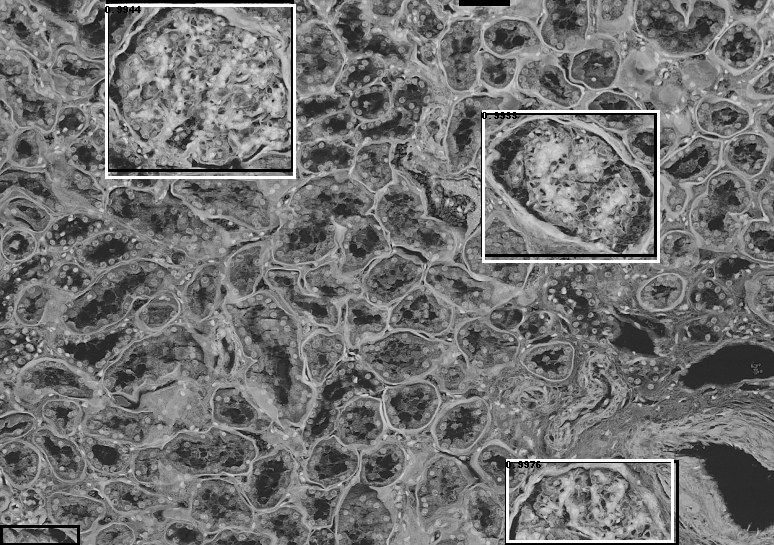

In [15]:
idx = 1
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])

# put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])

# turn the test images from tensor arrays to PIL image
x = img*255
image = ToPILImage()(x) 

# draw the boxes around the predicted glomeruli, return the image
draw = ImageDraw.Draw(image)
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="black", width =3)

for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    
    if score > 0.80:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
                        outline ='white', width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
                
image

### Make a test class

In [16]:
class TestingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'test/images/slices')))
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root,'test/images/slices', self.imgs[idx])
        img = tiff.imread(img_path)
        if len(img.shape) == 5:
            img = img.squeeze().transpose(1, 2, 0)
        
        # there is only one class
        image_id = torch.tensor([idx])
        imgid = self.imgs[idx]
        target = {}
        if self.transforms is not None:
            img = self.transforms(img, target)
        return img, imgid
    def __len__(self):
        return len(self.imgs)

In [17]:
testset = TestingDataset(root = '..', 
                         transforms = get_transform(train=False))
testset.__getitem__(0)

((tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8353],
           [0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8353],
           [0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8353],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8392],
           [0.0000, 0.0000, 0.0000,  ..., 0.8353, 0.8353, 0.8392],
           [0.0000, 0.0000, 0.0000,  ..., 0.8392, 0.8353, 0.8353]]]),
  {}),
 '26dc41664_0_0.tiff')

### Use model on Test images

In [18]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("../model/glomeruli_detection_model"))

<All keys matched successfully>

In [19]:
%%time
if torch.cuda.is_available():
    loaded_model.cuda()

loaded_model.eval()

predictions = []
for i in range(len(testset)):
    predict = {}
    tensor_img = testset[i][0][0][None, :,:].to(device)
    
    with torch.no_grad():
        preds = loaded_model(tensor_img)
        predictions.append(preds)

Wall time: 10min 26s


### Turn predictions into a dataframe and save as a csv

In [20]:
prediction =[]

In [21]:
predictions[0][0]

{'boxes': tensor([[ 21.2187,  20.8178, 348.1617, 579.3714]], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.1147], device='cuda:0')}

In [22]:
for x in range(len(predictions)):
    prediction.append(predictions[x][0])

In [23]:
test_preds = pd.DataFrame(prediction)

In [24]:
test_preds['filename'] = testset.imgs

In [25]:
test_preds = test_preds[['filename', 'boxes', 'scores', 'labels']]

In [26]:
test_preds.to_csv('../CSVs/test_preds.csv', index=False)

### Visualize predictions

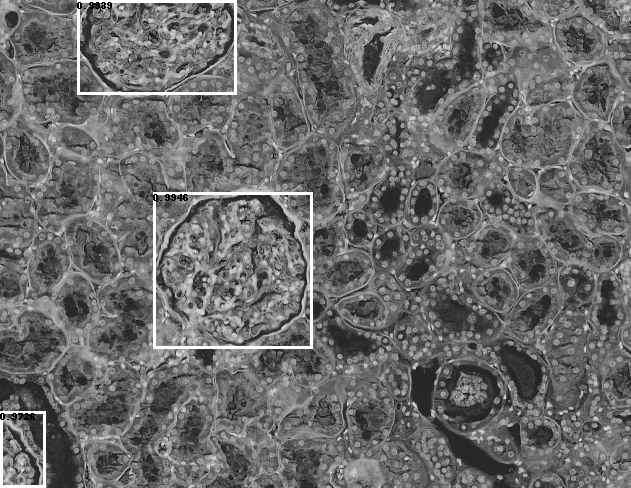

In [27]:
idx = 2635

img, _ = testset[idx][0]

# turn the test images from tensor arrays to PIL image
x = img*255
image = ToPILImage()(x) 

# draw the boxes around the predicted glomeruli, return the image
draw = ImageDraw.Draw(image)

for ele in range(len(test_preds.loc[idx]['boxes'])):
    boxes = prediction[idx]['boxes'][ele].cpu().numpy()
    score = np.round(prediction[idx]["scores"][ele].cpu().numpy(),
                    decimals= 4)
    if score > 0.91:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ='white', width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
image